# Base methods to deal with the test cases

In [77]:
import matplotlib.pyplot as plt  
%matplotlib inline
import pandas as pd
from pandas import DataFrame
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

### Base methods to deal with preprocessing data
- **fill_gaps** : *Method that deals with missing data from a dataframe*
- **normalize** : *Method that normalize data rescaling numerical values to a predefined range*
- **pca** : *Method that applies pca in a dataframe*

In [92]:
def fill_gaps(df, empty_token = '?'):
    imputer = SimpleImputer(missing_values = empty_token, strategy = 'most_frequent')
    result = imputer.fit_transform(df)
    
    result_df = DataFrame(result)
    result_df.columns = df.columns
    result_df.index = df.index
    return result_df

def normalize(df, columns, range=(0,1)):
    scaler = MinMaxScaler(feature_range=range)
    for col in columns:
        scaled_values = scaler.fit_transform(df[[col]].values.astype(float))
        df[col] = scaled_values
    return df

def pca(df, components = 70):
    pca = PCA(n_components = components)
    pca_values = pca.fit_transform(df)
    component_cols = []
    for i in range(0, components):
        component_cols.append('component_%s'%i)
    return DataFrame(data = pca_values, columns = component_cols)

def cost(fp, fn):
    return (fp * 500) + (fn*10)

def train_cluster(pre_train_df, pre_test_df):
    x_train = pre_train_df.iloc[:, 1:].values
#     y_train = pre_train_df['class'].values

    x_test = pre_test_df.iloc[:, 1:].values
    y_test = pre_test_df['class'].values
    y_test[y_test == 'neg'] = 0
    y_test[y_test == 'pos'] = 1

    kmeans = KMeans(n_clusters=2)  
    kmeans.fit(x_train)

#     display("Clusters labels: %s" % (kmeans.labels_))
#     display("Clusters centers: %s" % (kmeans.cluster_centers_))
    plt.scatter(x_train[:,0],x_train[:,1], c=kmeans.labels_, cmap='rainbow')
    plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c = 'green', label = 'Centroids')
    
    y_pred = kmeans.predict(x_test)
    
    display("y_test size: %s" % len((y_test)))
    display("y_pred size: %s" % len((y_pred)))
    display("y_test type: %s" % type((y_test)))
    display("y_pred type: %s" % type((y_pred)))
    # Check if there are values different than 0 and 1
    # print(((y_pred != 0) & (y_pred != 1)).any())
    
    accuracy = accuracy_score(y_test, y_pred)
    display("Accuracy %s" % (accuracy))
    tn, fp, fn, tp = confusion_matrix(y_pred, y_test).ravel()
    display ("False positives: %s - False Negatives %s" % (fp, fn))
    display("Cost: %s" % (cost(fp, fn)))
    

SyntaxError: invalid syntax (<ipython-input-92-da781bfcda8d>, line 52)

# Load the train and test datasets

In [79]:
train_df = pd.read_csv("aps_training_set_sample3.csv")
test_df = pd.read_csv("aps_failure_test_set.csv")

# Balancing classes in train dataset

In [80]:
# we need to balance the classes 
positive_class = train_df[train_df['class'] == 'pos']
qtd_pos = positive_class.shape[0]
negative_class = train_df[train_df['class'] == 'neg']
qtd_neg = negative_class.shape[0]

display("Positive samples: %s - Negative samples: %s" %(qtd_pos, qtd_neg))
new_samples = min(qtd_neg, qtd_pos)
display("Using %s samples per class" % (new_samples))


train_df = pd.concat([positive_class[:new_samples], negative_class[:new_samples]], ignore_index = True)
display(train_df['class'].value_counts())
train_df.shape

'Positive samples: 1000 - Negative samples: 2091'

'Using 1000 samples per class'

neg    1000
pos    1000
Name: class, dtype: int64

(2000, 171)

# Test Case 1
- fill_gaps
- Using DecisionTreeClassifier from sklearn

neg    1000
pos    1000
Name: class, dtype: int64

'y_test size: 16000'

'y_pred size: 16000'

"y_test type: <class 'numpy.ndarray'>"

"y_pred type: <class 'numpy.ndarray'>"

ValueError: Classification metrics can't handle a mix of unknown and binary targets

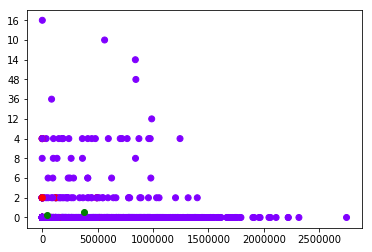

In [93]:
pre_train_df = fill_gaps(train_df)
pre_test_df = fill_gaps(test_df)

display(pre_train_df['class'].value_counts())

train_cluster(pre_train_df, pre_test_df)

# Test Case 2
- fill_gaps
- normalizing top 10 std_dev columns

In [6]:
pre_train_df = fill_gaps(train_df)
# Ignoring first column that is the label
for c in pre_train_df.columns[1:].values:
    pre_train_df[c] = pd.to_numeric(pre_train_df[c])
    
std_df = pre_train_df.std(axis = 0, skipna=True)
top10_std = std_df.sort_values(ascending=[False])[:10]
display(top10_std)
top10_std_columns = top10_std.index
pre_train_df = normalize(pre_train_df, columns = top10_std_columns)

pre_test_df = fill_gaps(test_df)
pre_test_df = normalize(pre_test_df, columns = top10_std_columns)

train_cluster(pre_train_df, pre_test_df)

ac_000    5.943633e+08
dq_000    2.818990e+08
eb_000    1.113884e+08
bb_000    3.246790e+07
bv_000    3.235481e+07
cq_000    3.235481e+07
bu_000    3.235481e+07
bx_000    3.090717e+07
cc_000    2.912746e+07
du_000    2.895663e+07
dtype: float64

'Accuracy 0.9220625'

'False positives: 21 - False Negatives 1226'

'Cost: 1268'

# Test Case 3
- fill gaps
- normalizing top 10 std_dev columns
- dimensionality reduction through pca

In [7]:
pca_train_df = pca(pre_train_df.loc[:, pre_train_df.columns != 'class'])
pca_test_df = pca(pre_test_df.loc[:, pre_train_df.columns != 'class'])

pca_train_df = pd.concat([pre_train_df['class'], pca_train_df], axis=1)
pca_test_df = pd.concat([pre_test_df['class'], pca_test_df], axis = 1)

train_cluster(pca_train_df, pca_test_df)

'Accuracy 0.0241875'

'False positives: 6 - False Negatives 15607'

'Cost: 15619'